In [666]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import scipy
import yaml
import matplotlib.pyplot as plt

sys.path.append('../')

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams
from abacus.splitter.split_builder import SplitBuilder
from abacus.splitter.params import SplitBuilderParams
from abacus.mde_researcher.params import MdeParams
from abacus.mde_researcher.mde_research_builder import MdeResearchBuilder
from abacus.mde_researcher.multiple_split_builder import MultipleSplitBuilder


logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Готовим данные

In [480]:
n_rows = 200_000

d = pd.DataFrame(data={
    'groups': np.random.choice(['control', 'treatment'], p=[0.5, 0.5], size=n_rows),
})

control_len = d.loc[d.groups == 'control'].shape[0]
treatment_len = d.loc[d.groups == 'treatment'].shape[0]

# user_id
d.loc[d.groups == 'control', 'user_id'] = np.random.randint(1, control_len-1500, control_len)
d.loc[d.groups == 'treatment', 'user_id'] = np.random.randint(control_len-1500+1, control_len-1500+1+treatment_len-1500, treatment_len)
d['user_id'] = d['user_id'].astype(int)

# demographics
d_unique = d.drop_duplicates(['user_id', 'groups'])
d_unique['gender'] = np.random.choice(['male', 'female'], p=[0.35, 0.65], size=d_unique.shape[0])
d_unique['age'] = np.random.randint(18, 68, size=d_unique.shape[0])
d_unique['city'] = np.random.choice(['Moscow', 'St.Petersburg', 'Kazan', 'Samara', 'Perm'], p=[0.59, 0.25, 0.06, 0.055, 0.045], size=d_unique.shape[0])
d = d.merge(d_unique, how='left', on=['user_id', 'groups'])

# check_rub, continuous target
checks_control_camp = np.round(np.random.gamma(2, 125, control_len), 1)  # mean = 200 rub
checks_treatment = np.random.gamma(2, 125, treatment_len)
checks_treatment_camp = np.round(checks_treatment + np.round(np.random.binomial(1, p=0.04, size=treatment_len), 1) * 80, 1)  # 20 rub uplift for 4% of treatment group
d.loc[d.groups == 'control', 'check_rub_campaign'] = checks_control_camp
d.loc[d.groups == 'treatment', 'check_rub_campaign'] = checks_treatment_camp

# check_rub, pre-campaign period
checks_control_pre_camp = np.absolute(checks_control_camp + np.random.normal(0, 10, len(checks_control_camp)))
checks_treatment_pre_camp = np.absolute(checks_treatment_camp + np.random.normal(0, 10, len(checks_treatment_camp)))
d.loc[d.groups == 'control', 'check_rub_pre_campaign'] = checks_control_pre_camp
d.loc[d.groups == 'treatment', 'check_rub_pre_campaign'] = checks_treatment_pre_camp

# has_transaction, binary target
d.loc[d.groups == 'control', 'has_transaction'] = np.random.binomial(1, p=0.04, size=control_len)
d.loc[d.groups == 'treatment', 'has_transaction'] = np.random.binomial(1, p=0.065, size=treatment_len)
d['has_transaction'] = d['has_transaction'].astype(int)

# ratio metric
d['clicks'] = np.random.gamma(1, 20, d.shape[0]).astype(int)
d['session_duration'] = np.round(np.random.gamma(1, 20, d.shape[0]), 1).astype(int)

d.to_csv('./data/ab_data_new.csv', index=False)
d.head()

,groups,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration
0,treatment,189963,male,64,Moscow,337.9,322.498048,0,12,91
1,control,42186,female,44,Perm,84.8,80.795804,0,18,7
2,control,3038,female,35,Moscow,428.9,410.870342,0,13,12
3,treatment,125577,male,49,St.Petersburg,401.4,416.752732,0,3,10
4,control,10191,male,53,St.Petersburg,122.8,108.475735,0,29,24


In [321]:
# import statsmodels.api as sm

# y = d['check_rub_campaign'].to_numpy()
# x_train = d[['gender', 'age', 'city']].to_numpy()
# model = sm.OLS(y, x_train)
# results = model.fit()

# print(results.summary())

Проверяем пересечение user_id в группах:

# Данные, с которыми будем работать

In [322]:
df = pd.read_csv('./data/ab_data_new.csv')
df.head()

,groups,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction
0,control,47542,male,64,Samara,164.4,154.193628,1
1,treatment,167063,female,61,St.Petersburg,65.1,64.248267,0
2,control,51292,female,35,Moscow,26.2,30.407282,0
3,control,7711,male,53,Kazan,579.8,585.625137,0
4,control,1586,male,51,St.Petersburg,101.4,97.601358,0


In [323]:
df.groupby(['groups']).check_rub_campaign.agg(['mean', 'count'])

,mean,count
groups,,
control,249.722249,100033
treatment,253.756524,99967


# Пост-анализ непрерывной метрики
## Инициализация теста, илюстрация, запуск теста и отчет

In [433]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='95th quantile',  # <----- стандартные: 'mean', 'median'; если использовать кастомную метрику, то функцию для нее нужно объявить
    metric=lambda x: np.quantile(x, 0.95),  # <----- здесь
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

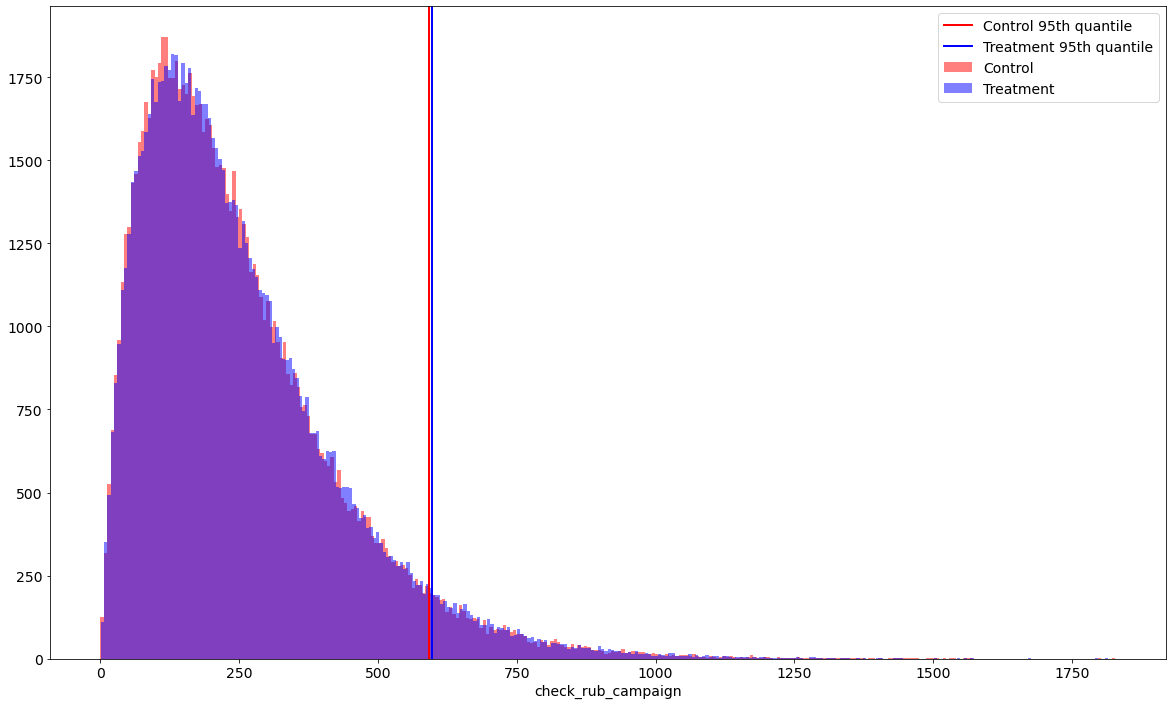

In [439]:
ab_test.plot()

In [326]:
ab_test.test_welch()

{'stat': 5.095147809096066, 'p-value': 1.743926295519406e-07, 'result': 1}

In [328]:
ab_test.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 100033
        - Mean: 249.7222
        - Median: 210.4000
        - 25th quantile: 119.6000
        - 75th quantile: 336.4000
        - Minimum: 0.2000
        - Maximum: 1885.8000
        - St.deviation: 177.7386
        - Variance: 31590.9955

        Treatment group:
        - Observations: 99967
        - Mean: 253.7565
        - Median: 213.7000
        - 25th quantile: 122.8000
        - 75th quantile: 341.7000
        - Minimum: 0.4000
        - Maximum: 1756.3000
        - St.deviation: 177.7386
        - Variance: 31590.9955

        No transformations applied.
        Number of bootstrap iterations: 1000. 

        Following statistical tests are used:
        - Welch's t-test: 5.10, p-value = 0.0000, H0 is rejected.
        - Mann Whitney's U-test: 4930727787.

## Фильтрация выбросов

In [402]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean',
    filter_method='top_5',  # <----- метод фильтрации метрики эксперимента: top_5, isolation_forest
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

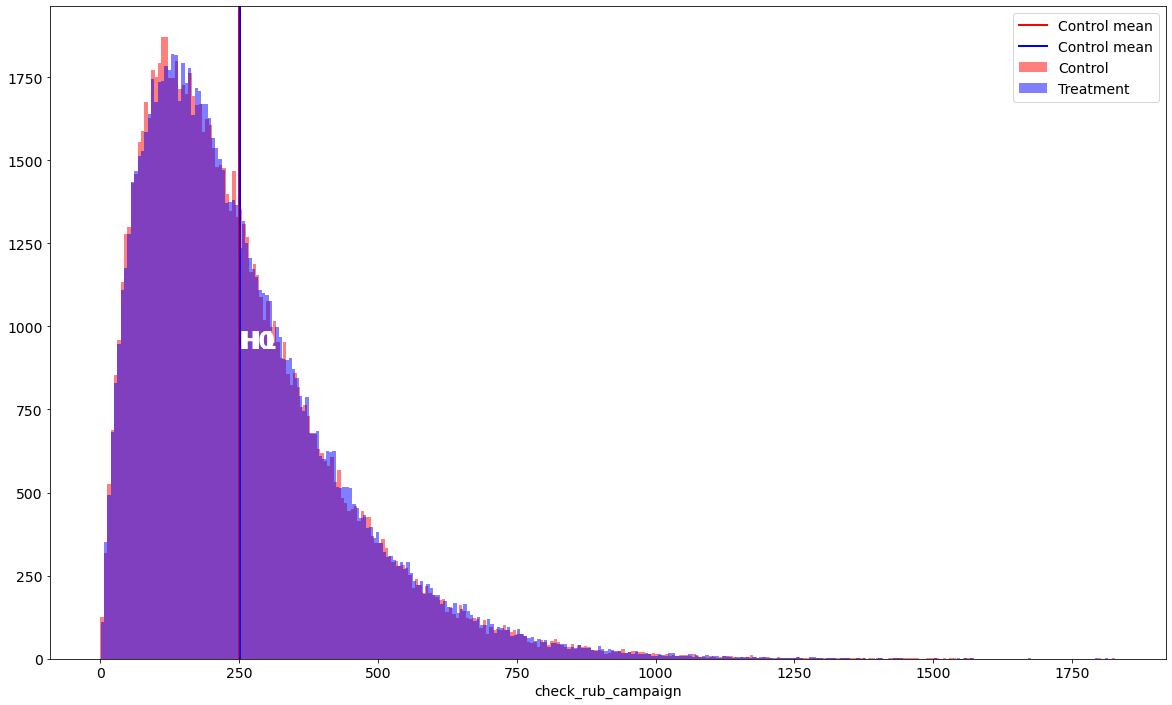

In [403]:
ab_test.plot()

In [406]:
ab_test.test_welch()

{'stat': 3.1154764586556727, 'p-value': 0.0009183698612269156, 'result': 1}

In [412]:
ab_test_1 = ab_test.filter_outliers()

Rows before: 200000
Rows left: 190001


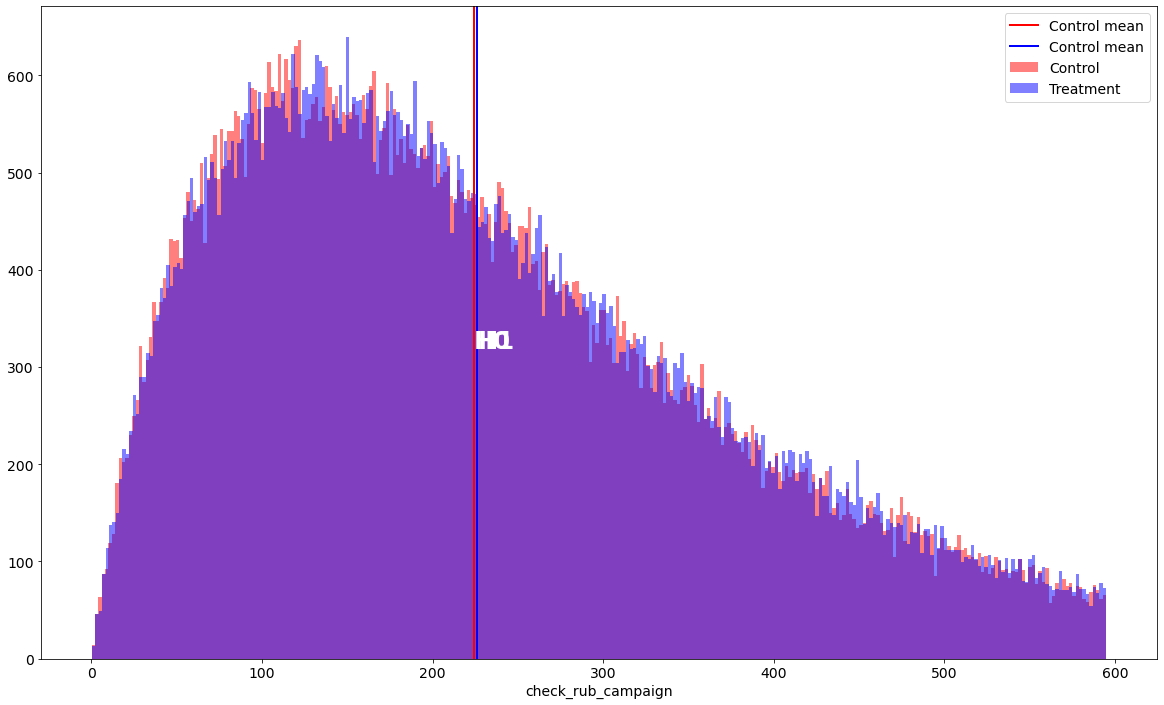

In [411]:
ab_test_1.plot()

## Функциональная трансформация метрики

In [329]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    metric_transform=np.sqrt,  # <----- добавлена трансформация
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

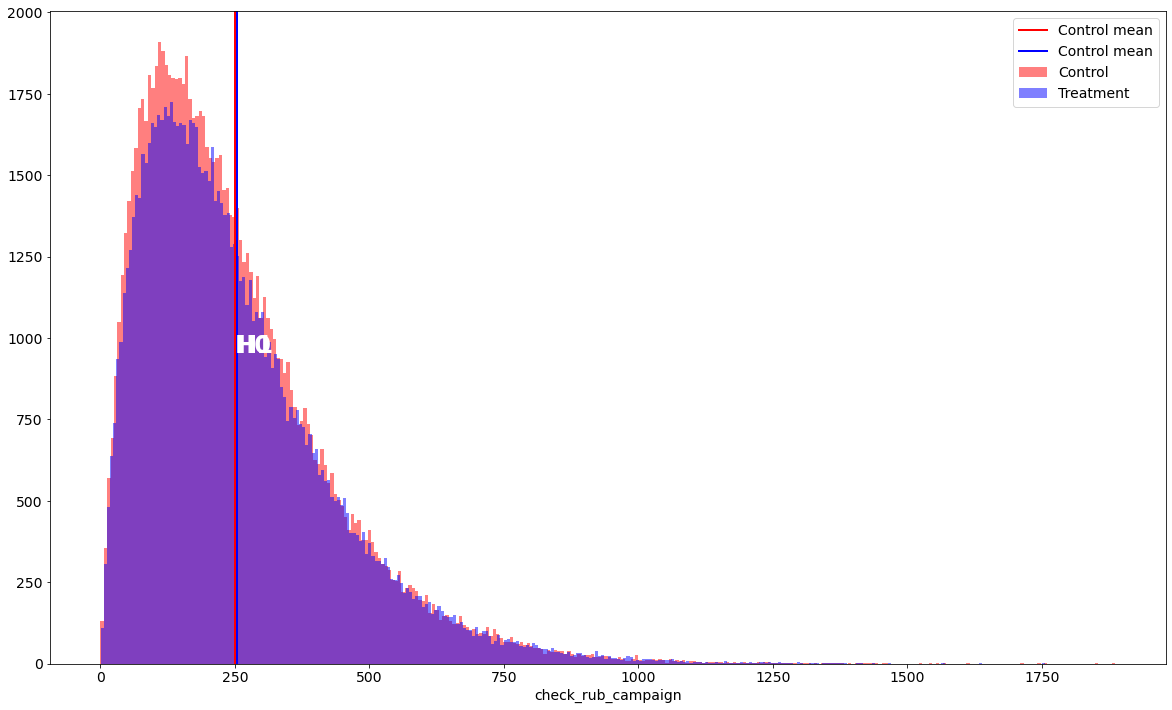

In [330]:
ab_test.plot()

In [331]:
ab_test_1 = ab_test.metric_transform()

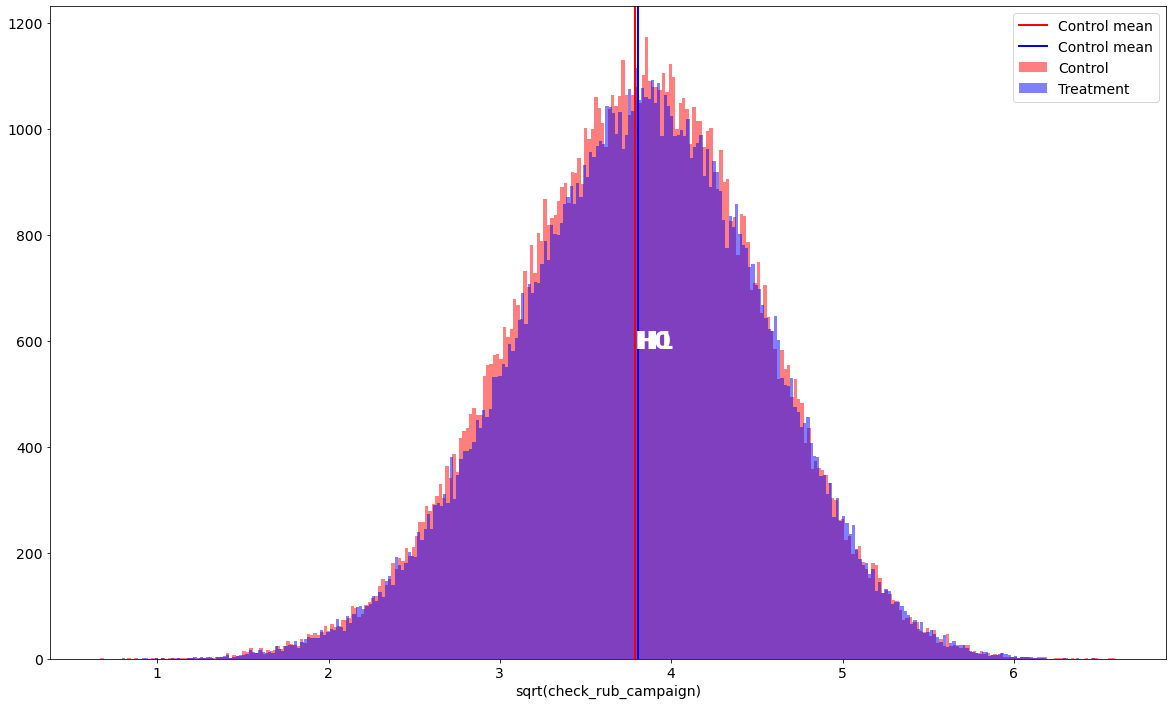

In [332]:
ab_test_1.plot()

In [333]:
ab_test_1.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 100033
        - Mean: 3.7879
        - Median: 3.8086
        - 25th quantile: 3.3070
        - 75th quantile: 4.2827
        - Minimum: 0.6687
        - Maximum: 6.5898
        - St.deviation: 0.7127
        - Variance: 0.5080

        Treatment group:
        - Observations: 99967
        - Mean: 3.8050
        - Median: 3.8234
        - 25th quantile: 3.3289
        - 75th quantile: 4.2994
        - Minimum: 0.7953
        - Maximum: 6.4737
        - St.deviation: 0.7127
        - Variance: 0.5080

        Transformations applied: metric transform.
        Number of bootstrap iterations: 1000. Metric transformation applied: sqrt. 

        Following statistical tests are used:
        - Welch's t-test: 5.37, p-value = 0.0000, H0 is rejected.
        - Mann Whitney's U

## Увеличение чувствительности метрики

In [354]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
    covariate='check_rub_pre_campaign',  # <----- добавляем информацию о ковариате
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [357]:
ab_test_1 = ab_test.cuped()

Среднее и ст.отклонение до CUPED:

In [363]:
print(np.mean(ab_test.params.data_params.control))
print(np.std(ab_test.params.data_params.control))

249.8689014774862
177.21644651574334


Среднее и ст.отклонение после CUPED:

In [362]:
print(np.mean(ab_test_1.params.data_params.control))
print(np.std(ab_test_1.params.data_params.control))

249.86890147748133
9.973593435603677


## Линеаризация и зависимые наблюдения

In [447]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=False,   # <----- данные не сгрупированы по user_id — по каждому user_id одна и более запись
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [448]:
print(f'Строк в старом датасете: {df.shape[0]}')
print(f'Уникальных user_id в старом датасете: {df.user_id.nunique()}')

Строк в старом датасете: 200000
Уникальных user_id в старом датасете: 125892


In [449]:
ab_test_1 = ab_test.linearization()

In [450]:
print('Строк в новом датасете: ' + str(ab_test_1._ABTest__dataset.shape[0]))
print('Уникальных user_id в новом датасете: ' + str(ab_test_1._ABTest__dataset.user_id.nunique()))

Строк в новом датасете: 125892
Уникальных user_id в новом датасете: 125892


In [451]:
ab_test_1._ABTest__dataset.head()

,groups,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,target_linearized
0,treatment,142889,female,23,Kazan,208.9,214.280719,0,-40.9689
1,control,57262,female,29,Moscow,42.1,50.913604,0,-207.7689
2,treatment,176187,male,18,Perm,249.5,245.942624,0,-112.2378
3,control,54612,female,38,Moscow,174.1,184.729590,0,-199.2378
4,control,5453,female,29,Moscow,240.7,230.755215,0,-9.1689


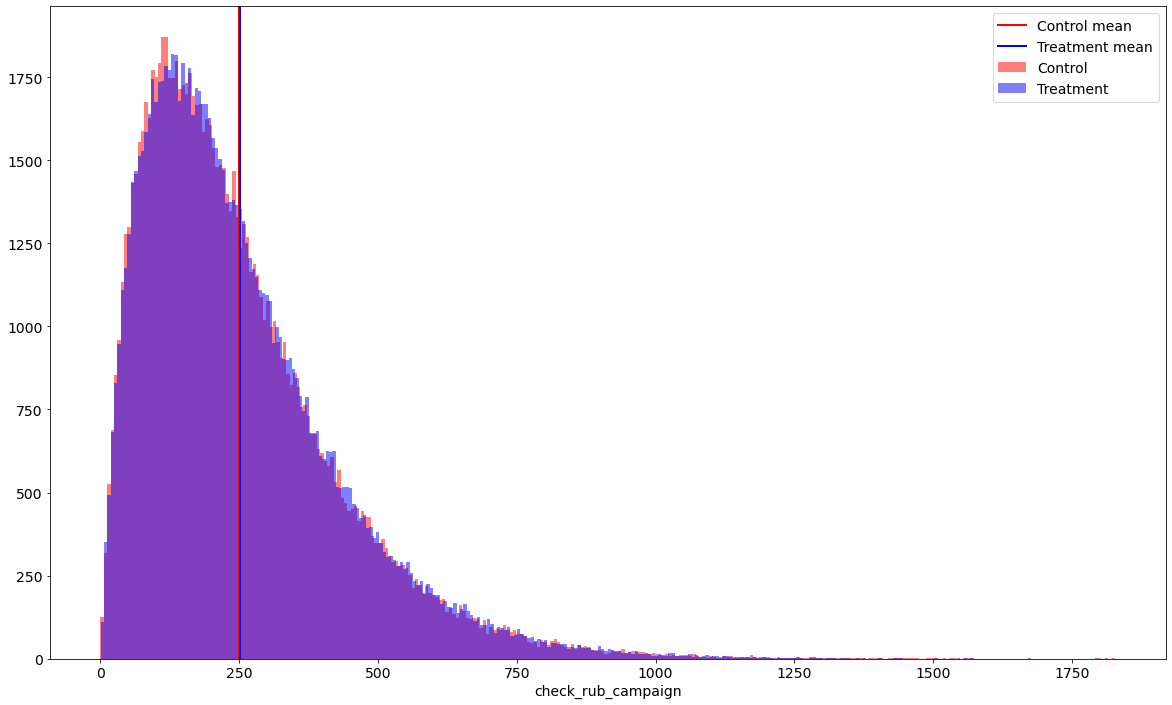

In [452]:
ab_test.plot()

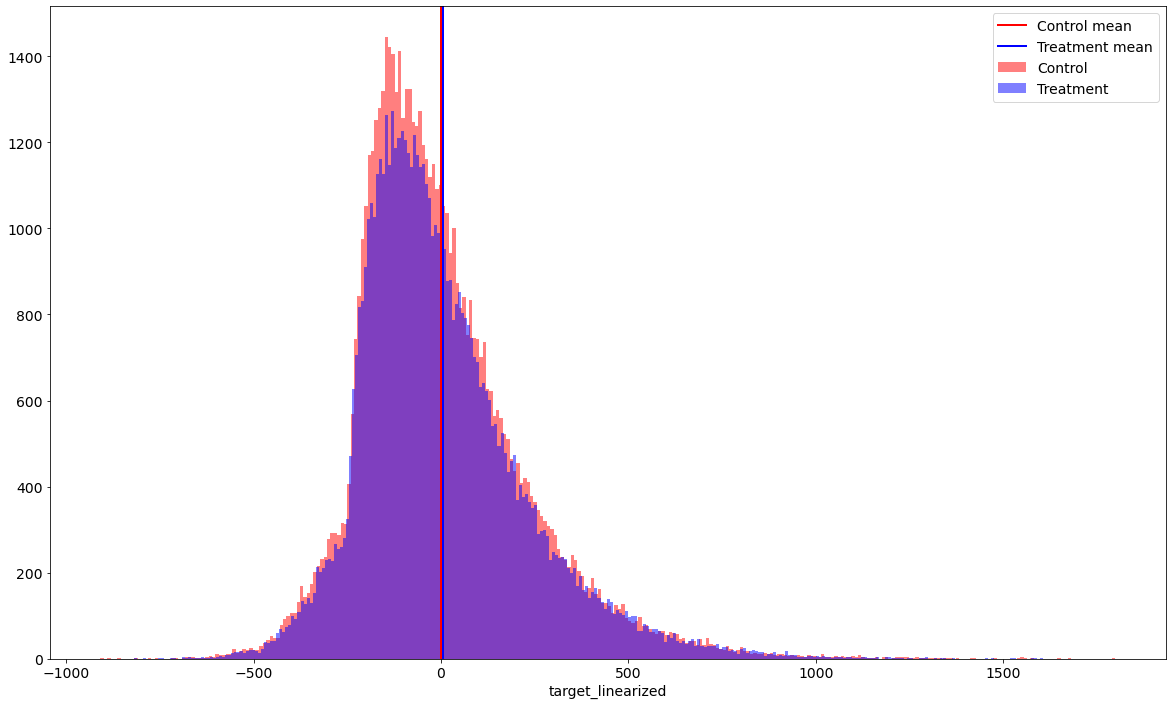

In [453]:
ab_test_1.plot()

In [454]:
ab_test.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 99561
        - Mean: 249.8689
        - Median: 209.6000
        - 25th quantile: 119.8000
        - 75th quantile: 335.6000
        - Minimum: 0.1000
        - Maximum: 1827.5000
        - St.deviation: 177.1699
        - Variance: 31389.1803

        Treatment group:
        - Observations: 100439
        - Mean: 252.3377
        - Median: 211.7000
        - 25th quantile: 122.4000
        - 75th quantile: 339.9000
        - Minimum: 0.4000
        - Maximum: 1815.3000
        - St.deviation: 177.1699
        - Variance: 31389.1803

        No transformations applied.
        Number of bootstrap iterations: 1000. 

        Following statistical tests are used:
        - Welch's t-test: 3.12, p-value = 0.0009, H0 is rejected.
        - Mann Whitney's U-test: 4952210089.

In [455]:
ab_test_1.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 62571
        - Mean: 0.0000
        - Median: -40.8689
        - 25th quantile: -148.1689
        - 75th quantile: 109.5311
        - Minimum: -908.5445
        - Maximum: 1797.6933
        - St.deviation: 222.3560
        - Variance: 49442.1686

        Treatment group:
        - Observations: 63321
        - Mean: 3.9160
        - Median: -37.2689
        - 25th quantile: -145.0067
        - 75th quantile: 113.6311
        - Minimum: -819.3134
        - Maximum: 1605.3933
        - St.deviation: 222.3560
        - Variance: 49442.1686

        Transformations applied: linearization.
        Number of bootstrap iterations: 1000. 

        Following statistical tests are used:
        - Welch's t-test: 3.12, p-value = 0.0009, H0 is rejected.
        - Mann Whitney's U-te

## Метрика-отношение

In [525]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=False,
    numerator='clicks',  # <----- числитель
    denominator='session_duration'  # <----- знаменатель
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='ratio', 
    metric_name='mean',  # <----- обязательное использование метрики "среднее"
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [526]:
ab_test.test_taylor_ratio()

{'stat': -20.06346061753186, 'p-value': None, 'result': 0}

Добавляем в числитель клики:

In [530]:
df1 = df.copy(deep=True)
df1.loc[df.groups == 'treatment', 'clicks'] = df1.loc[df1.groups == 'treatment', 'clicks'] \
                                                    + np.random.normal(2, 1, df1.loc[df.groups == 'treatment'].shape[0])
ab_test_up = ABTest(df1, ab_params)
ab_test_up.test_taylor_ratio()

{'stat': 452.8102414921475, 'p-value': None, 'result': 1}

Линеаризируем и смотрим результат после применения:

In [528]:
ab_test_1 = ab_test.linearization()
ab_test_up_1 = ab_test_up.linearization()

In [529]:
print(ab_test_1.test_welch())
print(ab_test_up_1.test_welch())

{'stat': -0.6724058815733444, 'p-value': 0.7493367126182489, 'result': 0}
{'stat': 15.151431998966926, 'p-value': 4.119271453564585e-52, 'result': 1}


## Бакетирование

In [456]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean',  # <----- обязательное использование метрики "среднее"
    n_boot_samples=1000,
    n_buckets=1000  # <----- количество бакетов
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

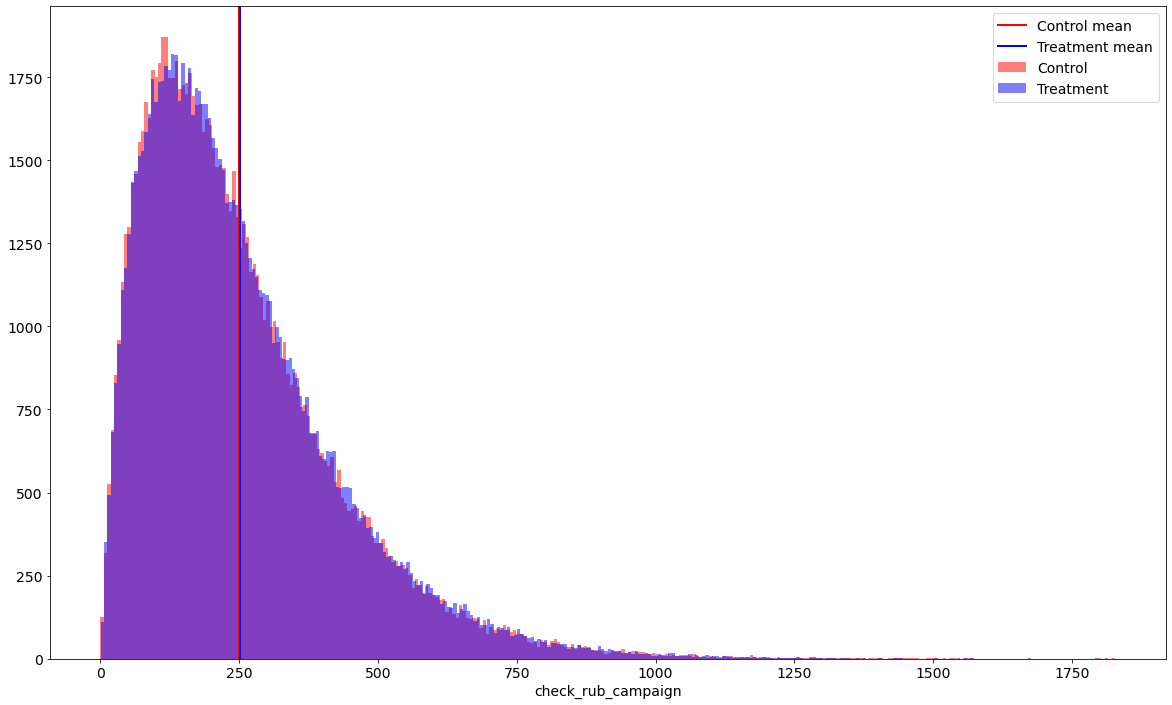

In [457]:
ab_test.plot()

In [458]:
ab_test_1 = ab_test.bucketing()

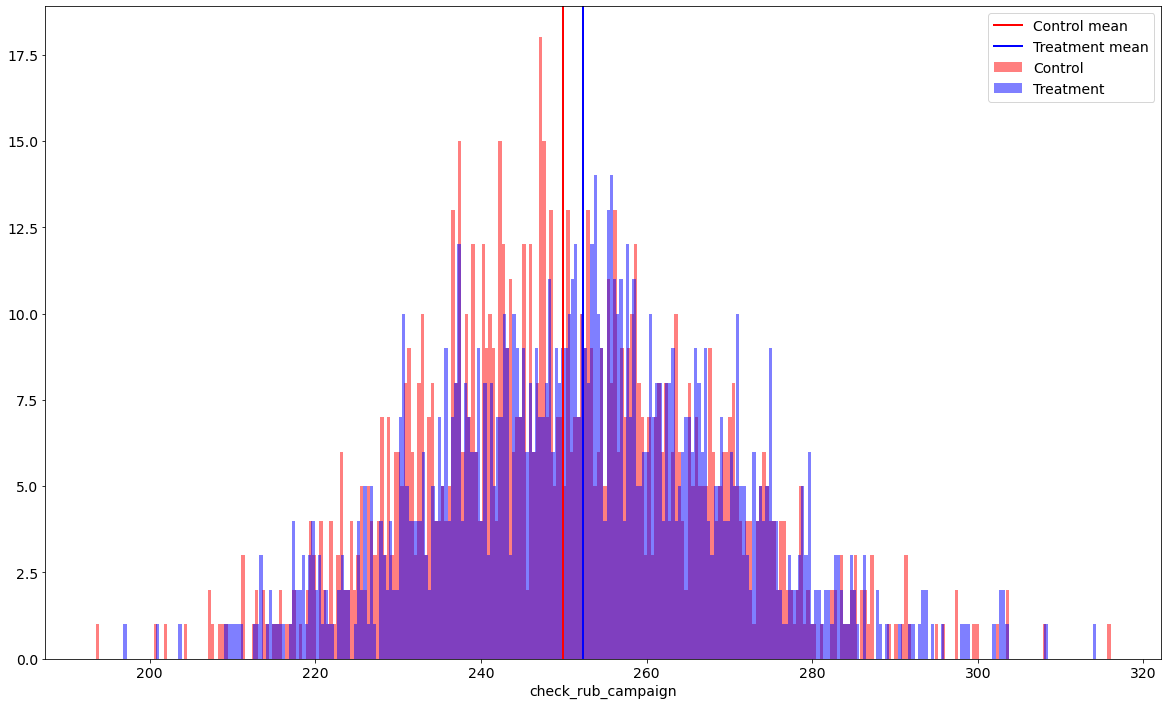

In [459]:
ab_test_1.plot()

Сравниваем средние до и после бакетирования:

In [464]:
print('До бакетирования:')
print(np.mean(ab_test.params.data_params.control))
print(np.mean(ab_test.params.data_params.treatment))
print('\nПосле бакетирования:')
print(np.mean(ab_test_1.params.data_params.control))
print(np.mean(ab_test_1.params.data_params.treatment))

До бакетирования:
249.86890147748616
252.3377423112536

После бакетирования:
249.86930191919194
252.3396230891089


## Всё вместе

In [562]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    covariate='check_rub_pre_campaign',
    is_grouped=False,
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='median',
    metric_transform=np.sqrt,
    filter_outliers='top_5',
    n_boot_samples=1000,
    n_buckets=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [563]:
ab_test = ABTest(df, ab_params).metric_transform().filter_outliers().linearization().cuped().bucketing()

In [564]:
ab_test.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: median.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 1000
        - Mean: 0.2205
        - Median: 0.2326
        - 25th quantile: 0.1160
        - 75th quantile: 0.3450
        - Minimum: -0.6086
        - Maximum: 0.7122
        - St.deviation: 0.1882
        - Variance: 0.0354

        Treatment group:
        - Observations: 1000
        - Mean: 0.3420
        - Median: 0.3522
        - 25th quantile: 0.2331
        - 75th quantile: 0.4725
        - Minimum: -0.6369
        - Maximum: 0.8563
        - St.deviation: 0.1882
        - Variance: 0.0354

        Transformations applied: metric transform -> filter outliers -> linearization -> cuped -> bucketing.
        Number of bootstrap iterations: 1000. Number of buckets: 1000. Metric transformation applied: sqrt. Outliers filtering method applied: top_5. 

        Foll

# Пост-анализ для метрики "конверсия"
## Инициализация теста, иллюстрация, запуск теста и отчет

In [540]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop_duplicates(['user_id'])

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target_flg='has_transaction'  # <----- для конверсии задаем целевую колонку в этот аргумент
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='binary', 
    metric_name='mean',  # <----- обязательное использование метрики "среднее"
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [541]:
ab_test.report()


        Parameters of experiment:
        - Metric type: binary.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 62892
        - Conversion: 0.038669465114799975

        Treatment group:
        - Observations: 62886
        - Conversion: 0.06576980568011959

        No transformations applied.

        Following statistical tests are used:
        - Z-test: 21.60, p-value = 0.0000, H0 is rejected.
        - Chi-square test: 1242.29, p-value = 0.0000, H0 is rejected.

        All two stat. tests showed that H0 is rejected.
        


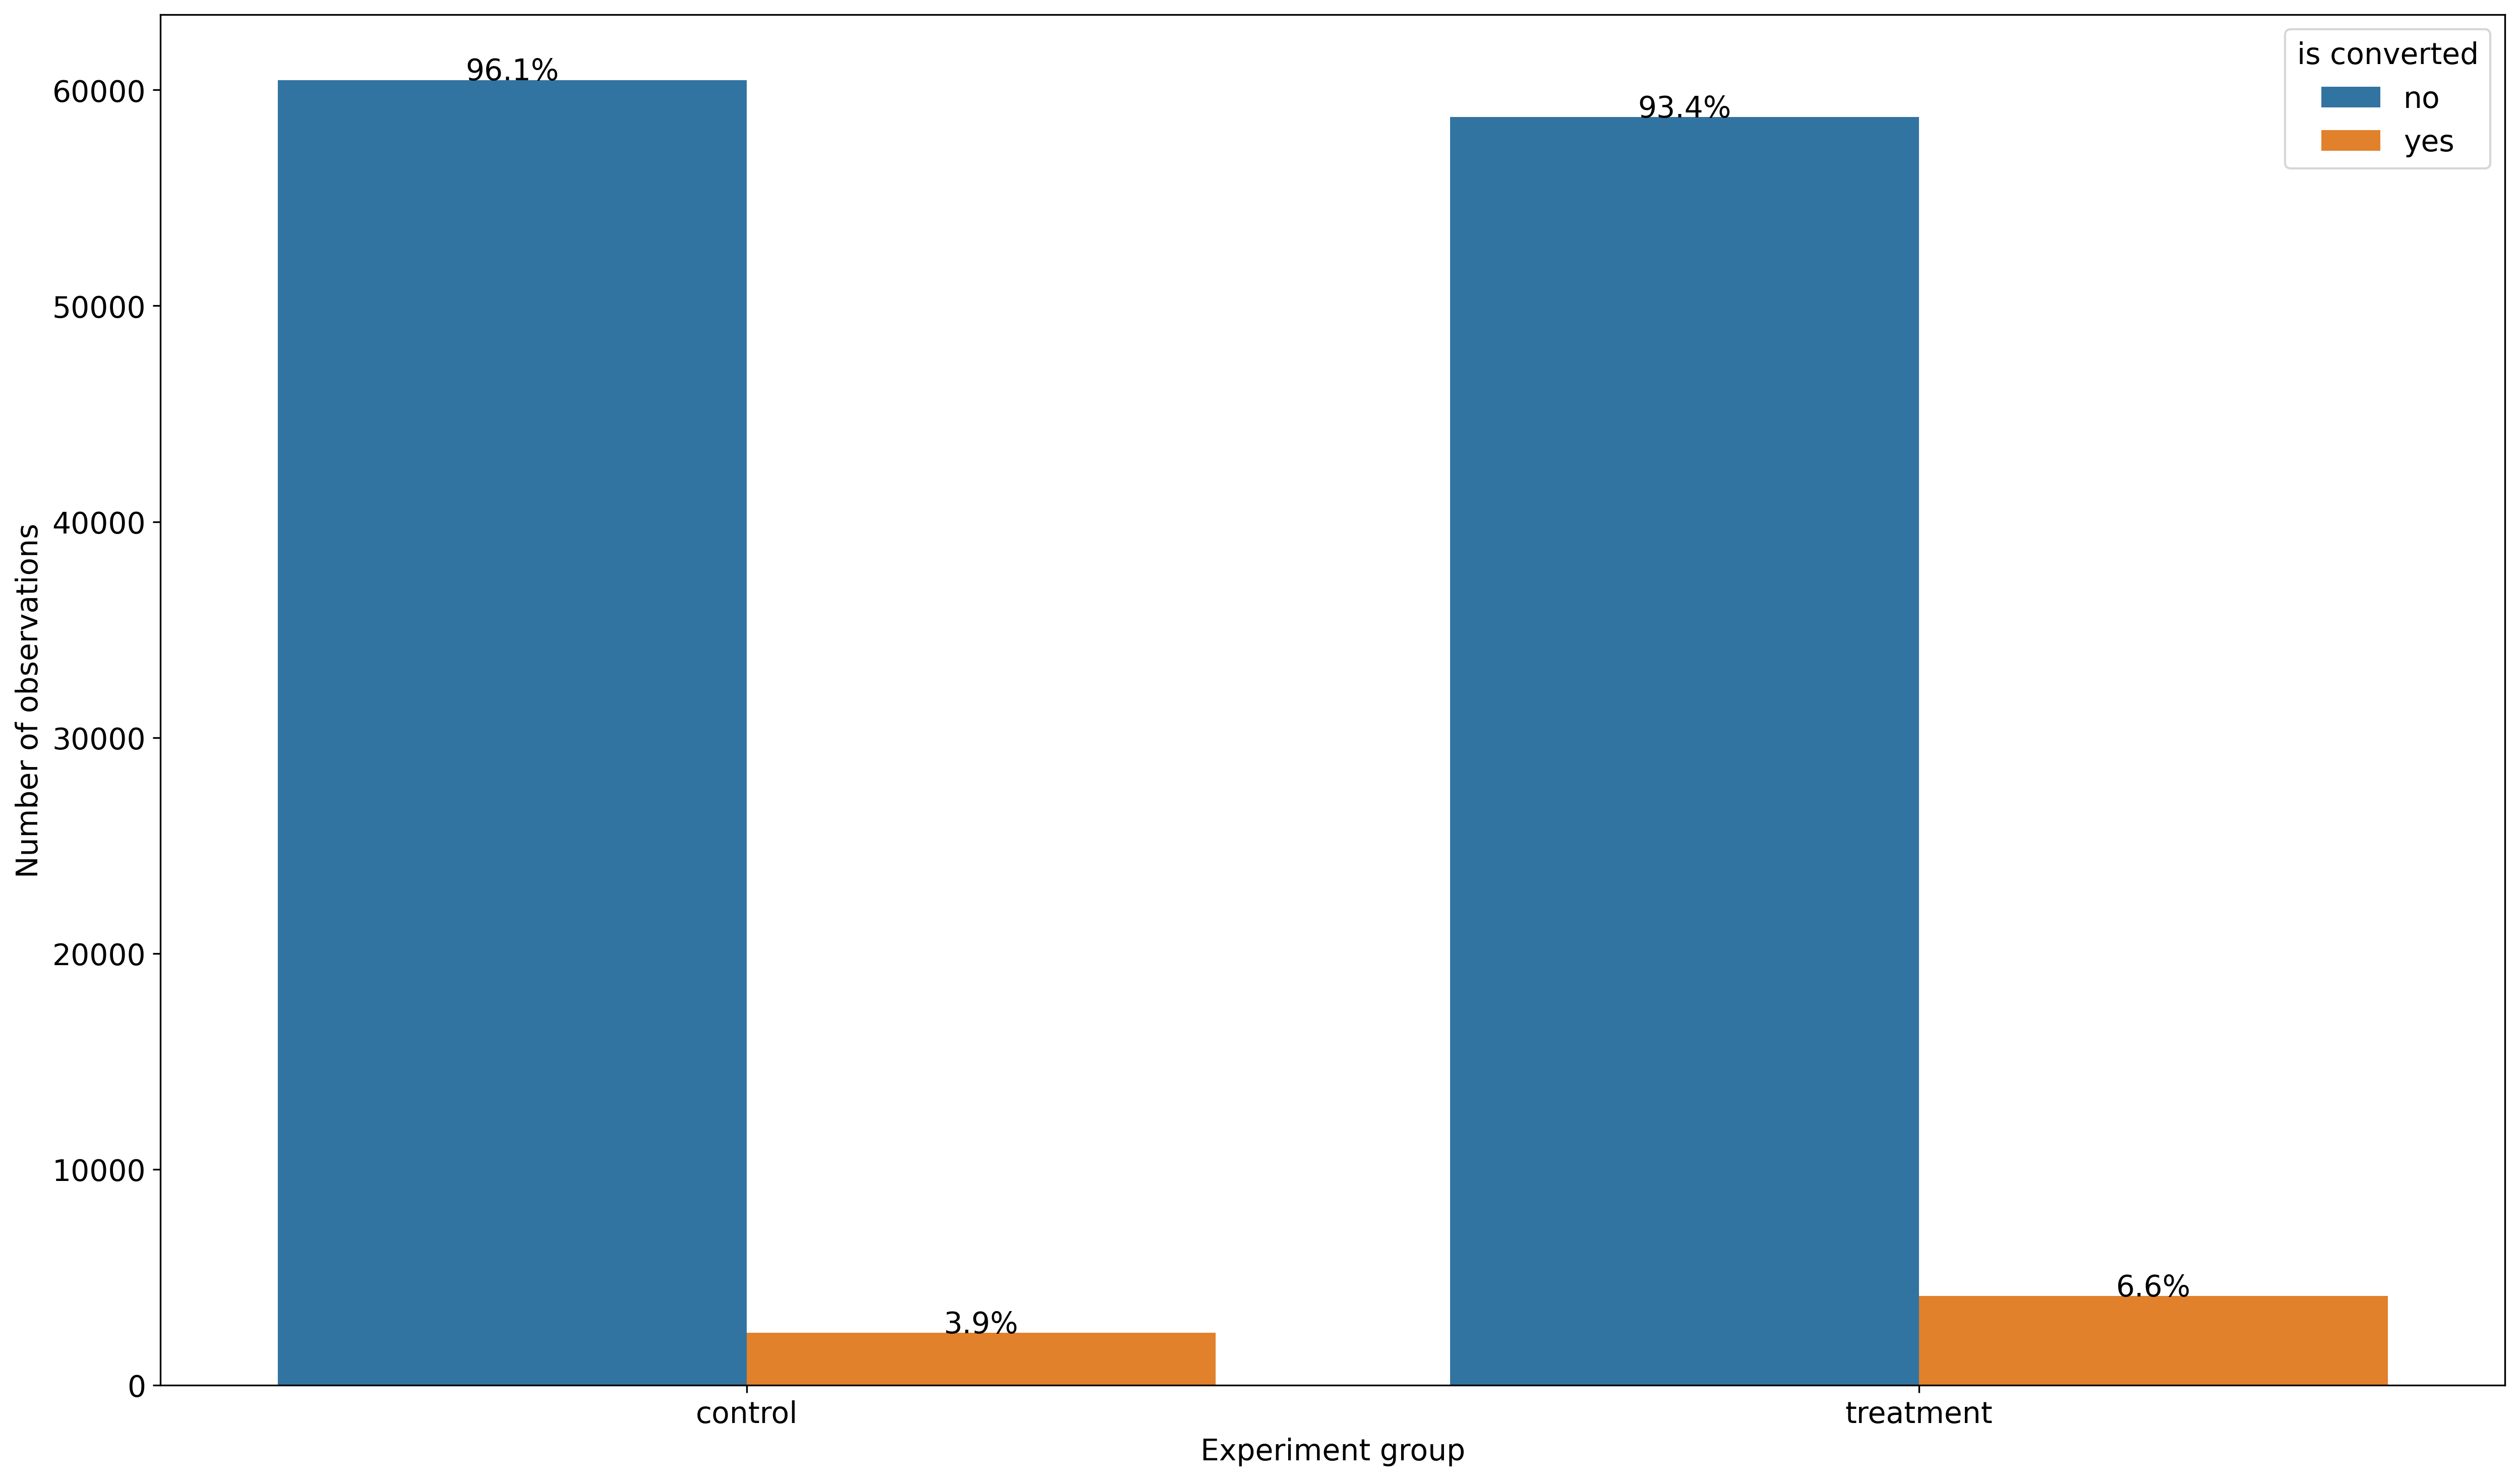

In [542]:
ab_test.plot()

# Выделение групп эксперимента
## Разделение на группы всех имеющихся данных

In [649]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop(columns=['groups'])
df = df.drop_duplicates(['user_id'])

In [644]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "city",
    split_metric_col = "check_rub_campaign",
    id_col = "user_id",
    cols = ["check_rub_pre_campaign"],
    cat_cols=["gender"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 100
)

In [645]:
split_builder = SplitBuilder(df, split_builder_params)

In [646]:
split = split_builder.collect()

In [647]:
split.head()

,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration,strata,group_name
0,189963,0.351604,64,Moscow,337.9,322.498048,0,12,91,Moscow4-1,target
1,42186,0.648396,44,Perm,84.8,80.795804,0,18,7,Perm0-1,control
2,3038,0.648396,35,Moscow,428.9,410.870342,0,13,12,Moscow5-1,control
3,125577,0.351604,49,St.Petersburg,401.4,416.752732,0,3,10,St.Petersburg4-1,control
4,10191,0.351604,53,St.Petersburg,122.8,108.475735,0,29,24,St.Petersburg1-1,target


In [648]:
print(f'Количество строк исходно: {df.shape[0]}')
print(f'Количество строк в сплите: {split.shape[0]}')

Количество строк исходно: 125778
Количество строк в сплите: 125778


## Разделение на группы с требуемым размером

In [650]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop(columns=['groups'])
df = df.drop_duplicates(['user_id'])

In [651]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': 20_000,  # <----- размер контрольной группы
        'target': 30_000  # <----- размер тестовой группы
    },
    main_strata_col = "city",
    split_metric_col = "check_rub_campaign",
    id_col = "user_id",
    cols = ["check_rub_pre_campaign"],
    cat_cols=["gender"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

In [652]:
split_builder = SplitBuilder(df, split_builder_params)

In [653]:
split = split_builder.collect()

In [654]:
split.head()

,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration,strata,group_name
0,189963,0.351604,64,Moscow,337.9,322.498048,0,12,91,Moscow4-1,target
1,27297,0.648397,31,Moscow,231.3,228.023670,0,4,17,Moscow3-1,control
2,3849,0.351604,50,Moscow,501.6,511.261485,0,12,15,Moscow5-1,control
3,85797,0.648397,26,Samara,474.6,483.766226,0,6,18,Samara5-1,control
4,117775,0.648397,66,Moscow,37.2,34.252079,0,60,10,Moscow0-1,target


In [655]:
print(f'Количество строк исходно: {df.shape[0]}')
print(f'Количество строк в сплите: {split.shape[0]}')
print(f'Количество строк в контроле: {split[split.group_name == "control"].shape[0]}')
print(f'Количество строк в тесте: {split[split.group_name == "target"].shape[0]}')

Количество строк исходно: 125778
Количество строк в сплите: 50000
Количество строк в контроле: 19999
Количество строк в тесте: 30001


# Подбор параметров эксперимента
## Непрерывная метрика, без трансформаций

In [667]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop_duplicates(['user_id'])

In [668]:
data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign' 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [669]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None, 
        'target': None
    },
    main_strata_col = "city",
    split_metric_col = "check_rub_campaign",
    id_col = "user_id",
    cols = ["check_rub_pre_campaign"],
    cat_cols=["gender"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

In [716]:
experiment_params = MdeParams(
    metrics_names=['check_rub_campaign'],
    injects=[1.010, 1.013, 1.015, 1.018, 1.02, 1.030],
    min_group_size=5_000, 
    max_group_size=30_000, 
    step=5_000,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_welch,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [717]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [718]:
beta, alpha = prepilot.collect()

In [719]:
beta

split_rate              (5000, 5000) (10000, 10000) (15000, 15000)  \
metric             MDE                                               
check_rub_campaign 1.0%        >=0.9          >=0.9          >=0.9   
                   1.3%        >=0.9          >=0.9          >=0.9   
                   1.5%        >=0.9          >=0.9          >=0.9   
                   1.8%        >=0.9          >=0.9            0.6   
                   2.0%        >=0.9            0.8            0.3   
                   3.0%        >=0.9          <=0.2          <=0.2   

split_rate              (20000, 20000) (25000, 25000) (30000, 30000)  
metric             MDE                                                
check_rub_campaign 1.0%          >=0.9          >=0.9          >=0.9  
                   1.3%          >=0.9            0.8            0.4  
                   1.5%            0.5          <=0.2          <=0.2  
                   1.8%            0.3          <=0.2          <=0.2  
                   2.0%          <=0.2          <=0.2          <=0.2  
                   3.0%          <=0.2          <=0.2          <=0.2

In [720]:
alpha

split_rate,"(5000, 5000)","(10000, 10000)","(15000, 15000)","(20000, 20000)","(25000, 25000)","(30000, 30000)"
metric,,,,,,
check_rub_campaign,0.0,0.0,0.0,0.0,0.0,0.0


## Непрерывная метрика, понижение дисперсии

In [722]:
data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
    covariate='check_rub_pre_campaign'  # <----- добавили ковариату
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [723]:
experiment_params = MdeParams(
    metrics_names=['check_rub_campaign'],
    injects=[1.010, 1.013, 1.015, 1.018, 1.02, 1.030],
    min_group_size=5_000, 
    max_group_size=30_000, 
    step=5_000,
    variance_reduction=ABTest.cuped,
    use_buckets=False,
    stat_test=ABTest.test_welch,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [724]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [725]:
beta, alpha = prepilot.collect()

In [726]:
beta

split_rate              (5000, 5000) (10000, 10000) (15000, 15000)  \
metric             MDE                                               
check_rub_campaign 1.0%        <=0.2          <=0.2          <=0.2   
                   1.3%        <=0.2          <=0.2          <=0.2   
                   1.5%        <=0.2          <=0.2          <=0.2   
                   1.8%        <=0.2          <=0.2          <=0.2   
                   2.0%        <=0.2          <=0.2          <=0.2   
                   3.0%        <=0.2          <=0.2          <=0.2   

split_rate              (20000, 20000) (25000, 25000) (30000, 30000)  
metric             MDE                                                
check_rub_campaign 1.0%          <=0.2          <=0.2          <=0.2  
                   1.3%          <=0.2          <=0.2          <=0.2  
                   1.5%          <=0.2          <=0.2          <=0.2  
                   1.8%          <=0.2          <=0.2          <=0.2  
                   2.0%          <=0.2          <=0.2          <=0.2  
                   3.0%          <=0.2          <=0.2          <=0.2

In [727]:
alpha

split_rate,"(5000, 5000)","(10000, 10000)","(15000, 15000)","(20000, 20000)","(25000, 25000)","(30000, 30000)"
metric,,,,,,
check_rub_campaign,0.3,0.4,0.5,0.3,0.4,0.3


## Непрерывная метрика, бакетирование

In [728]:
experiment_params = MdeParams(
    metrics_names=['check_rub_campaign'],
    injects=[1.010, 1.013, 1.015, 1.018, 1.02, 1.030],
    min_group_size=5_000, 
    max_group_size=30_000, 
    step=5_000,
    variance_reduction=ABTest.cuped,
    use_buckets=True,
    stat_test=ABTest.test_welch,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [729]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [730]:
beta, alpha = prepilot.collect()

In [731]:
beta

split_rate              (5000, 5000) (10000, 10000) (15000, 15000)  \
metric             MDE                                               
check_rub_campaign 1.0%        <=0.2          <=0.2          <=0.2   
                   1.3%        <=0.2          <=0.2          <=0.2   
                   1.5%        <=0.2          <=0.2          <=0.2   
                   1.8%        <=0.2          <=0.2          <=0.2   
                   2.0%        <=0.2          <=0.2          <=0.2   
                   3.0%        <=0.2          <=0.2          <=0.2   

split_rate              (20000, 20000) (25000, 25000) (30000, 30000)  
metric             MDE                                                
check_rub_campaign 1.0%          <=0.2          <=0.2          <=0.2  
                   1.3%          <=0.2          <=0.2          <=0.2  
                   1.5%          <=0.2          <=0.2          <=0.2  
                   1.8%          <=0.2          <=0.2          <=0.2  
                   2.0%          <=0.2          <=0.2          <=0.2  
                   3.0%          <=0.2          <=0.2          <=0.2

In [733]:
alpha

split_rate,"(5000, 5000)","(10000, 10000)","(15000, 15000)","(20000, 20000)","(25000, 25000)","(30000, 30000)"
metric,,,,,,
check_rub_campaign,0.5,0.5,0.4,0.4,0.1,0.2


## Бинарная метрика

In [740]:
data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target_flg='has_transaction', 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='binary', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [757]:
experiment_params = MdeParams(
    metrics_names=['has_transaction'],
    injects=[1.05, 1.10, 1.15, 1.20],
    min_group_size=10_000, 
    max_group_size=30_000, 
    step=10_000,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_z_proportions,
    iterations_number=100,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [758]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [759]:
beta, alpha = prepilot.collect()

In [760]:
beta

split_rate            (10000, 10000) (20000, 20000) (30000, 30000)
metric          MDE                                               
has_transaction 10.0%           0.79           0.53           0.29
                15.0%            0.5          <=0.2          <=0.2
                20.0%          <=0.2          <=0.2          <=0.2
                5.0%           >=0.9           0.87           0.78

In [761]:
alpha

split_rate,"(10000, 10000)","(20000, 20000)","(30000, 30000)"
metric,,,
has_transaction,0.02,0.01,0.0
